## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [ ]:
!pip install seaborn xgboost

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [66]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [67]:
df['price']=np.log1p(df['price'])

In [68]:
df['price']

0        5.010635
1        5.420535
2        5.017280
3        4.499810
4        4.394449
           ...   
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: price, Length: 48895, dtype: float64

In [69]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [71]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [77]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [73]:
train_dicts = df_train.to_dict(orient='records')

In [74]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [78]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [79]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



c:\users\kma\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [81]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [85]:
y_pred = rf.predict(X_val)
_rmse = round(mean_squared_error(y_val, y_pred, squared=False),3)
_rmse

0.462

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

Wall time: 38 s


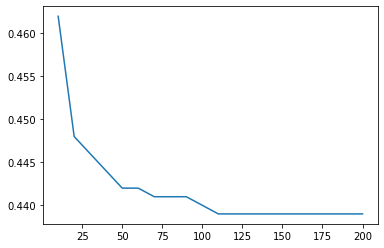

In [86]:
%%time
scores=[]
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n,
                                    random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    _rmse = round(mean_squared_error(y_val, y_pred, squared=False),3)
    scores.append((n, _rmse))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [89]:
%%time
scores=[]
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,max_depth=d,
                                        random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        _rmse = round(mean_squared_error(y_val, y_pred, squared=False),3)
        scores.append((d, n, _rmse))
df_scores = pd.DataFrame(scores, columns=['depth','n_estimators', 'rmse'])
# plt.plot(df_scores.n_estimators, df_scores.rmse)

Wall time: 1min 52s


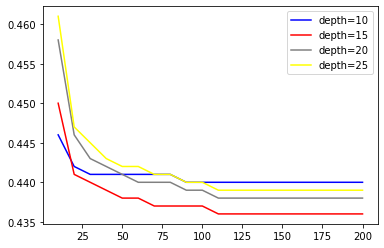

In [90]:
colors = ['blue', 'red', 'grey', 'yellow']
values = [10, 15, 20, 25]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.depth == s]
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             color=col,
             label='depth=%d' % s)

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [91]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1, 
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [95]:
start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.009 seconds


c:\users\kma\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


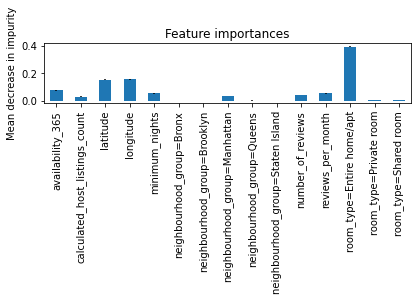

In [102]:
forest_importances = pd.Series(importances, index=dv.get_feature_names())
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [104]:
import xgboost as xgb

In [105]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [111]:
for eta in [0.3, 0.1, 0.01]:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:3.02752	val-rmse:3.02415
[1]	train-rmse:2.14667	val-rmse:2.14390
[2]	train-rmse:1.53878	val-rmse:1.53721
[3]	train-rmse:1.12557	val-rmse:1.12523
[4]	train-rmse:0.85100	val-rmse:0.85174
[5]	train-rmse:0.67490	val-rmse:0.67752
[6]	train-rmse:0.56687	val-rmse:0.57148
[7]	train-rmse:0.50448	val-rmse:0.51139
[8]	train-rmse:0.46913	val-rmse:0.47777
[9]	train-rmse:0.45009	val-rmse:0.45965
[10]	train-rmse:0.43912	val-rmse:0.44981
[11]	train-rmse:0.43327	val-rmse:0.44475
[12]	train-rmse:0.42936	val-rmse:0.44210
[13]	train-rmse:0.42668	val-rmse:0.44038
[14]	train-rmse:0.42463	val-rmse:0.43943
[15]	train-rmse:0.42259	val-rmse:0.43827
[16]	train-rmse:0.42113	val-rmse:0.43772
[17]	train-rmse:0.42074	val-rmse:0.43787
[18]	train-rmse:0.41896	val-rmse:0.43744
[19]	train-rmse:0.41812	val-rmse:0.43726
[20]	train-rmse:0.41716	val-rmse:0.43691
[21]	train-rmse:0.41499	val-rmse:0.43645
[22]	train-rmse:0.41437	val-rmse:0.43611
[23]	train-rmse:0.41403	val-rmse:0.43614
[24]	train-rmse:0.41391	va

[0]	train-rmse:4.25336	val-rmse:4.25010
[1]	train-rmse:4.21141	val-rmse:4.20815
[2]	train-rmse:4.16988	val-rmse:4.16661
[3]	train-rmse:4.12877	val-rmse:4.12551
[4]	train-rmse:4.08807	val-rmse:4.08481
[5]	train-rmse:4.04779	val-rmse:4.04454
[6]	train-rmse:4.00792	val-rmse:4.00467
[7]	train-rmse:3.96845	val-rmse:3.96521
[8]	train-rmse:3.92937	val-rmse:3.92615
[9]	train-rmse:3.89070	val-rmse:3.88749
[10]	train-rmse:3.85242	val-rmse:3.84921
[11]	train-rmse:3.81452	val-rmse:3.81133
[12]	train-rmse:3.77701	val-rmse:3.77382
[13]	train-rmse:3.73988	val-rmse:3.73671
[14]	train-rmse:3.70313	val-rmse:3.69996
[15]	train-rmse:3.66674	val-rmse:3.66359
[16]	train-rmse:3.63073	val-rmse:3.62759
[17]	train-rmse:3.59508	val-rmse:3.59195
[18]	train-rmse:3.55979	val-rmse:3.55666
[19]	train-rmse:3.52487	val-rmse:3.52175
[20]	train-rmse:3.49030	val-rmse:3.48719
[21]	train-rmse:3.45608	val-rmse:3.45298
[22]	train-rmse:3.42220	val-rmse:3.41910
[23]	train-rmse:3.38867	val-rmse:3.38559
[24]	train-rmse:3.35548	va

0.3-	    train-rmse:0.36478	val-rmse:0.43621 \
0.1-	    train-rmse:0.40277	val-rmse:0.43250 \
0.01-	train-rmse:1.63198	val-rmse:1.63045

Now change `eta` first to `0.1` and then to `0.01`

What's the best eta?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

